In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

In [2]:
def read_label():
    label = {}
    for i in range(1, 6):
        hi = 'data/ukdale/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
        label[i]['mains'] = 'mains'
    return label
labels = read_label()
# for i in range(1,3):
#     print('House {}: '.format(i), labels[i], '\n')
for i in range(1,2):
    print('House {}: '.format(i), labels[i], '\n')

House 1:  {1: 'aggregate_1', 2: 'boiler_2', 3: 'solar_thermal_pump_3', 4: 'laptop_4', 5: 'washing_machine_5', 6: 'dishwasher_6', 7: 'tv_7', 8: 'kitchen_lights_8', 9: 'htpc_9', 10: 'kettle_10', 11: 'toaster_11', 12: 'fridge_12', 13: 'microwave_13', 14: 'lcd_office_14', 15: 'hifi_office_15', 16: 'breadmaker_16', 17: 'amp_livingroom_17', 18: 'adsl_router_18', 19: 'livingroom_s_lamp_19', 20: 'soldering_iron_20', 21: 'gigE_&_USBhub_21', 22: 'hoover_22', 23: 'kitchen_dt_lamp_23', 24: 'bedroom_ds_lamp_24', 25: 'lighting_circuit_25', 26: 'livingroom_s_lamp2_26', 27: 'iPad_charger_27', 28: 'subwoofer_livingroom_28', 29: 'livingroom_lamp_tv_29', 30: 'DAB_radio_livingroom_30', 31: 'kitchen_lamp2_31', 32: 'kitchen_phone&stereo_32', 33: 'utilityrm_lamp_33', 34: 'samsung_charger_34', 35: 'bedroom_d_lamp_35', 36: 'coffee_machine_36', 37: 'kitchen_radio_37', 38: 'bedroom_chargers_38', 39: 'hair_dryer_39', 40: 'straighteners_40', 41: 'iron_41', 42: 'gas_oven_42', 43: 'data_logger_pc_43', 44: 'childs_ta

In [3]:
def get_house_path(house):
    return f'data/ukdale/house_{house}/'
    
def get_chan_path(house, channel):
    return get_house_path(house) + f'channel_{channel}.dat'

def get_num_apps(house):
    return len(glob.glob(get_house_path(house) + 'channel_*[0-9].dat'))

def read_file(house, channel):
    file = get_chan_path(house, channel)
    
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][channel]], 
                                       dtype = {'unix_time': 'int64', labels[house][channel]:'float64'}) 

    return df

def parse_data(df, sort_index = True, drop_duplicates = True):
#     df.insert(0, 'line_nr', range(0, len(df)))
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time'], axis=1, inplace=True)

#     tz = 'US/Eastern'
#     # Convert the integer index column to timezone-aware datetime 
#     df.index = pd.to_datetime(df.index.values, unit='s', utc=True)
#     df = df.tz_convert(tz)

    if sort_index:
        df = df.sort_index() # raw REDD data isn't always sorted
        
        
#     df.drop(['unix_time','timestamp'], axis=1, inplace=True)
        
    if drop_duplicates:
        dups_in_index = df.index.duplicated(keep='first')
        if dups_in_index.any():
#             print('Data has duplicates', house, channel, dups_in_index[dups_in_index == True])
            df = df[~dups_in_index]

    return df

def get_timeframe(df):
    start = df.index[0]
    end = df.index[-1]
    
    return start, end

In [4]:
DATA_SIZE_LIMIT = 17000000

In [5]:
parsed_labels = {}
def parse_labels(house):
    parsed_labels[house] = {}
    parsed_labels[house][1] = labels[house][1]
    num_apps = get_num_apps(house)
    
    for i in range(2, num_apps + 1):
        data = read_file(house, i)
        
        if data.shape[0] >= DATA_SIZE_LIMIT:
            if i == 2 or i % 7 == 0: 
                print('parsing label', house, i)
            parsed_labels[house][i] = labels[house][i]
            
    return parsed_labels

In [6]:
for i in range(1,2):
    parsed_labels = parse_labels(i)

parsing label 1 2
parsing label 1 7
parsing label 1 28
parsing label 1 35
parsing label 1 42
parsing label 1 49


In [7]:
def read_merge_data(house):
    print(f'reading house {house}; channel {1}');
    df = read_file(house, 1)
    df = parse_data(df)
    path = f'data/ukdale/house_{house}/'

    #     file = path + 'mains.dat'
#     df = pd.read_table(file, sep = ' ', names = ['unix_time', 'mains_active_p_w', 'mains_apparent_p_va', 'mains_rms_v' ], 
#                                        dtype = {'unix_time': 'float64', 'mains_active_p_w':'float64', 'mains_apparent_p_va': 'float64', 'mains_rms_v': 'float64'}) 
#     df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    
    num_apps = get_num_apps(house)


    # tv_7, fridge_12, microwave_13, gas_oven_42
#     for i in [7, 52, 53]:
    for i in range(2, num_apps + 1):
        data = read_file(house, i)
        if data.shape[0] >= DATA_SIZE_LIMIT:
            print(f'reading house {house}; channel {i}; df.shape is {df.shape}; data.shape is {data.shape}')
            data = parse_data(data)

            start_x, end_x = get_timeframe(data)
            start_y, end_y = get_timeframe(df)

            start = start_x if start_x > start_y else start_y
            end = end_x if end_x < end_y else end_y

            data = data[(data.index >= start) &
                                   (data.index <= end)]
            df = df[(df.index >= start) &
                                   (df.index <= end)]

            df = pd.merge_asof(df, data, on = 'timestamp', tolerance=pd.Timedelta('6s'))
            df = df.set_index(df['timestamp'].values)
        else:
            print(f'skipping house {house}; channel {i}; df.shape is {df.shape}; data.shape is {data.shape}')
#         df = pd.merge(df, data, how = 'inner', on = 'unix_time')

    return df

df = {}
# for i in range(1,3):
#     df[i] = read_merge_data(i)
for i in range(1,2):
    df[i] = read_merge_data(i)

reading house 1; channel 1
reading house 1; channel 2; df.shape is (21837636, 2); data.shape is (21281331, 2)
reading house 1; channel 3; df.shape is (21837634, 3); data.shape is (21281208, 2)
skipping house 1; channel 4; df.shape is (21837632, 4); data.shape is (4539118, 2)
reading house 1; channel 5; df.shape is (21837632, 4); data.shape is (19555935, 2)
reading house 1; channel 6; df.shape is (21837632, 5); data.shape is (19819392, 2)
reading house 1; channel 7; df.shape is (21837632, 6); data.shape is (19763329, 2)
reading house 1; channel 8; df.shape is (21837632, 7); data.shape is (21449386, 2)
reading house 1; channel 9; df.shape is (21802477, 8); data.shape is (19543268, 2)
reading house 1; channel 10; df.shape is (21568110, 9); data.shape is (18881051, 2)
reading house 1; channel 11; df.shape is (21568110, 10); data.shape is (19404267, 2)
reading house 1; channel 12; df.shape is (21568110, 11); data.shape is (19381298, 2)
reading house 1; channel 13; df.shape is (21568110, 12)

In [8]:
print(parsed_labels)

{1: {1: 'aggregate_1', 2: 'boiler_2', 3: 'solar_thermal_pump_3', 5: 'washing_machine_5', 6: 'dishwasher_6', 7: 'tv_7', 8: 'kitchen_lights_8', 9: 'htpc_9', 10: 'kettle_10', 11: 'toaster_11', 12: 'fridge_12', 13: 'microwave_13', 17: 'amp_livingroom_17', 18: 'adsl_router_18', 19: 'livingroom_s_lamp_19', 25: 'lighting_circuit_25', 26: 'livingroom_s_lamp2_26', 28: 'subwoofer_livingroom_28', 29: 'livingroom_lamp_tv_29', 32: 'kitchen_phone&stereo_32', 33: 'utilityrm_lamp_33', 34: 'samsung_charger_34', 35: 'bedroom_d_lamp_35', 36: 'coffee_machine_36', 37: 'kitchen_radio_37', 42: 'gas_oven_42', 43: 'data_logger_pc_43', 44: 'childs_table_lamp_44', 45: 'childs_ds_lamp_45', 46: 'baby_monitor_tx_46', 48: 'office_lamp1_48', 49: 'office_lamp2_49'}}


In [18]:
def print_heads_tails(h=True,t=True):
    for i in range(1,2):
        print('House {} data has shape: '.format(i), df[i].shape)
        if h:
            display(df[i].head(2))

        print()

        if t:
            display(df[i].tail(2))

print_heads_tails(t=False)

House 1 data has shape:  (19843093, 34)


,aggregate_1,timestamp,boiler_2,solar_thermal_pump_3,washing_machine_5,dishwasher_6,tv_7,kitchen_lights_8,htpc_9,kettle_10,...,coffee_machine_36,kitchen_radio_37,gas_oven_42,data_logger_pc_43,childs_table_lamp_44,childs_ds_lamp_45,baby_monitor_tx_46,office_lamp1_48,office_lamp2_49,timeslice
2013-04-11 19:09:00,675.0,2013-04-11 19:09:00,0.0,0.0,0.0,1.0,97.0,0.0,88.0,1.0,...,1.0,1.0,46.0,12.0,0.0,0.0,0.0,14.0,0.0,19
2013-04-11 19:09:06,679.0,2013-04-11 19:09:06,12.0,0.0,0.0,1.0,96.0,0.0,68.0,1.0,...,1.0,1.0,46.0,13.0,0.0,0.0,0.0,14.0,10.0,19


In [10]:
for i in range(1,2):
    path = f'data/ukdale/house_{i}/'
    num_apps = len(glob.glob(path + 'channel_*[0-9].dat'))
    for j in range(1, num_apps + 1):
        if j in parsed_labels[i] and df[i][parsed_labels[i][j]].isnull().sum() > 0:
            print(f'interpolating house {i}; channel {j}; {parsed_labels[i][j]}. prev NaN count was {df[i][parsed_labels[i][j]].isnull().sum()}')
            df[i][parsed_labels[i][j]].interpolate(method='linear', inplace=True)
            df[i][parsed_labels[i][j]].fillna(0.0, inplace=True)

interpolating house 1; channel 2; boiler_2. prev NaN count was 765506
interpolating house 1; channel 3; solar_thermal_pump_3. prev NaN count was 765514
interpolating house 1; channel 5; washing_machine_5. prev NaN count was 1667216
interpolating house 1; channel 6; dishwasher_6. prev NaN count was 1369906
interpolating house 1; channel 7; tv_7. prev NaN count was 1389617
interpolating house 1; channel 8; kitchen_lights_8. prev NaN count was 445893
interpolating house 1; channel 9; htpc_9. prev NaN count was 1352039
interpolating house 1; channel 10; kettle_10. prev NaN count was 2095235
interpolating house 1; channel 11; toaster_11. prev NaN count was 1488614
interpolating house 1; channel 12; fridge_12. prev NaN count was 1504595
interpolating house 1; channel 13; microwave_13. prev NaN count was 1498069
interpolating house 1; channel 17; amp_livingroom_17. prev NaN count was 1352802
interpolating house 1; channel 18; adsl_router_18. prev NaN count was 1385381
interpolating house 1; c

In [11]:
print_heads_tails()

House 1 data has shape:  (19843093, 33)


,aggregate_1,timestamp,boiler_2,solar_thermal_pump_3,washing_machine_5,dishwasher_6,tv_7,kitchen_lights_8,htpc_9,kettle_10,...,bedroom_d_lamp_35,coffee_machine_36,kitchen_radio_37,gas_oven_42,data_logger_pc_43,childs_table_lamp_44,childs_ds_lamp_45,baby_monitor_tx_46,office_lamp1_48,office_lamp2_49
2013-04-11 19:09:00,675.0,2013-04-11 19:09:00,0.0,0.0,0.0,1.0,97.0,0.0,88.0,1.0,...,0.0,1.0,1.0,46.0,12.0,0.0,0.0,0.0,14.0,0.0
2013-04-11 19:09:06,679.0,2013-04-11 19:09:06,12.0,0.0,0.0,1.0,96.0,0.0,68.0,1.0,...,0.0,1.0,1.0,46.0,13.0,0.0,0.0,0.0,14.0,10.0


,aggregate_1,timestamp,boiler_2,solar_thermal_pump_3,washing_machine_5,dishwasher_6,tv_7,kitchen_lights_8,htpc_9,kettle_10,...,bedroom_d_lamp_35,coffee_machine_36,kitchen_radio_37,gas_oven_42,data_logger_pc_43,childs_table_lamp_44,childs_ds_lamp_45,baby_monitor_tx_46,office_lamp1_48,office_lamp2_49
2017-03-19 10:58:50,2534.0,2017-03-19 10:58:50,13.0,51.0,2198.5,1.0,0.0,0.0,3.5,1.0,...,0.0,1.0,1.0,3.0,13.0,0.0,8.0,0.0,0.5,0.0
2017-03-19 10:58:57,2526.0,2017-03-19 10:58:57,12.0,51.0,2157.0,1.0,0.0,0.0,4.0,1.0,...,0.0,1.0,1.0,3.0,14.0,0.0,8.0,0.0,1.0,0.0


In [13]:
def add_time_slice_feature(df):
    for i in range(1,2):
        df[i]['timeslice'] = df[i].timestamp.dt.hour

add_time_slice_feature(df)

In [19]:
print_heads_tails(t=False)

House 1 data has shape:  (19843093, 34)


,aggregate_1,timestamp,boiler_2,solar_thermal_pump_3,washing_machine_5,dishwasher_6,tv_7,kitchen_lights_8,htpc_9,kettle_10,...,coffee_machine_36,kitchen_radio_37,gas_oven_42,data_logger_pc_43,childs_table_lamp_44,childs_ds_lamp_45,baby_monitor_tx_46,office_lamp1_48,office_lamp2_49,timeslice
2013-04-11 19:09:00,675.0,2013-04-11 19:09:00,0.0,0.0,0.0,1.0,97.0,0.0,88.0,1.0,...,1.0,1.0,46.0,12.0,0.0,0.0,0.0,14.0,0.0,19
2013-04-11 19:09:06,679.0,2013-04-11 19:09:06,12.0,0.0,0.0,1.0,96.0,0.0,68.0,1.0,...,1.0,1.0,46.0,13.0,0.0,0.0,0.0,14.0,10.0,19


In [20]:
dates = {}
for i in range(1,2):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 1431 days from 2013-04-11 to 2017-03-19.
['2013-04-11', '2013-04-12', '2013-04-13', '2013-04-14', '2013-04-15', '2013-04-16', '2013-04-17', '2013-04-18', '2013-04-19', '2013-04-20', '2013-04-21', '2013-04-22', '2013-04-23', '2013-04-24', '2013-04-25', '2013-04-26', '2013-04-27', '2013-04-28', '2013-04-29', '2013-04-30', '2013-05-01', '2013-05-02', '2013-05-03', '2013-05-04', '2013-05-05', '2013-05-06', '2013-05-07', '2013-05-08', '2013-05-09', '2013-05-10', '2013-05-11', '2013-05-12', '2013-05-13', '2013-05-14', '2013-05-15', '2013-05-16', '2013-05-17', '2013-05-18', '2013-05-19', '2013-05-20', '2013-05-21', '2013-05-22', '2013-05-23', '2013-05-24', '2013-05-25', '2013-05-26', '2013-05-27', '2013-05-28', '2013-05-29', '2013-05-30', '2013-05-31', '2013-06-01', '2013-06-02', '2013-06-03', '2013-06-04', '2013-06-05', '2013-06-06', '2013-06-07', '2013-06-08', '2013-06-09', '2013-06-10', '2013-06-11', '2013-06-12', '2013-06-13', '2013-06-14', '2013-06-15', '2013-06-16',

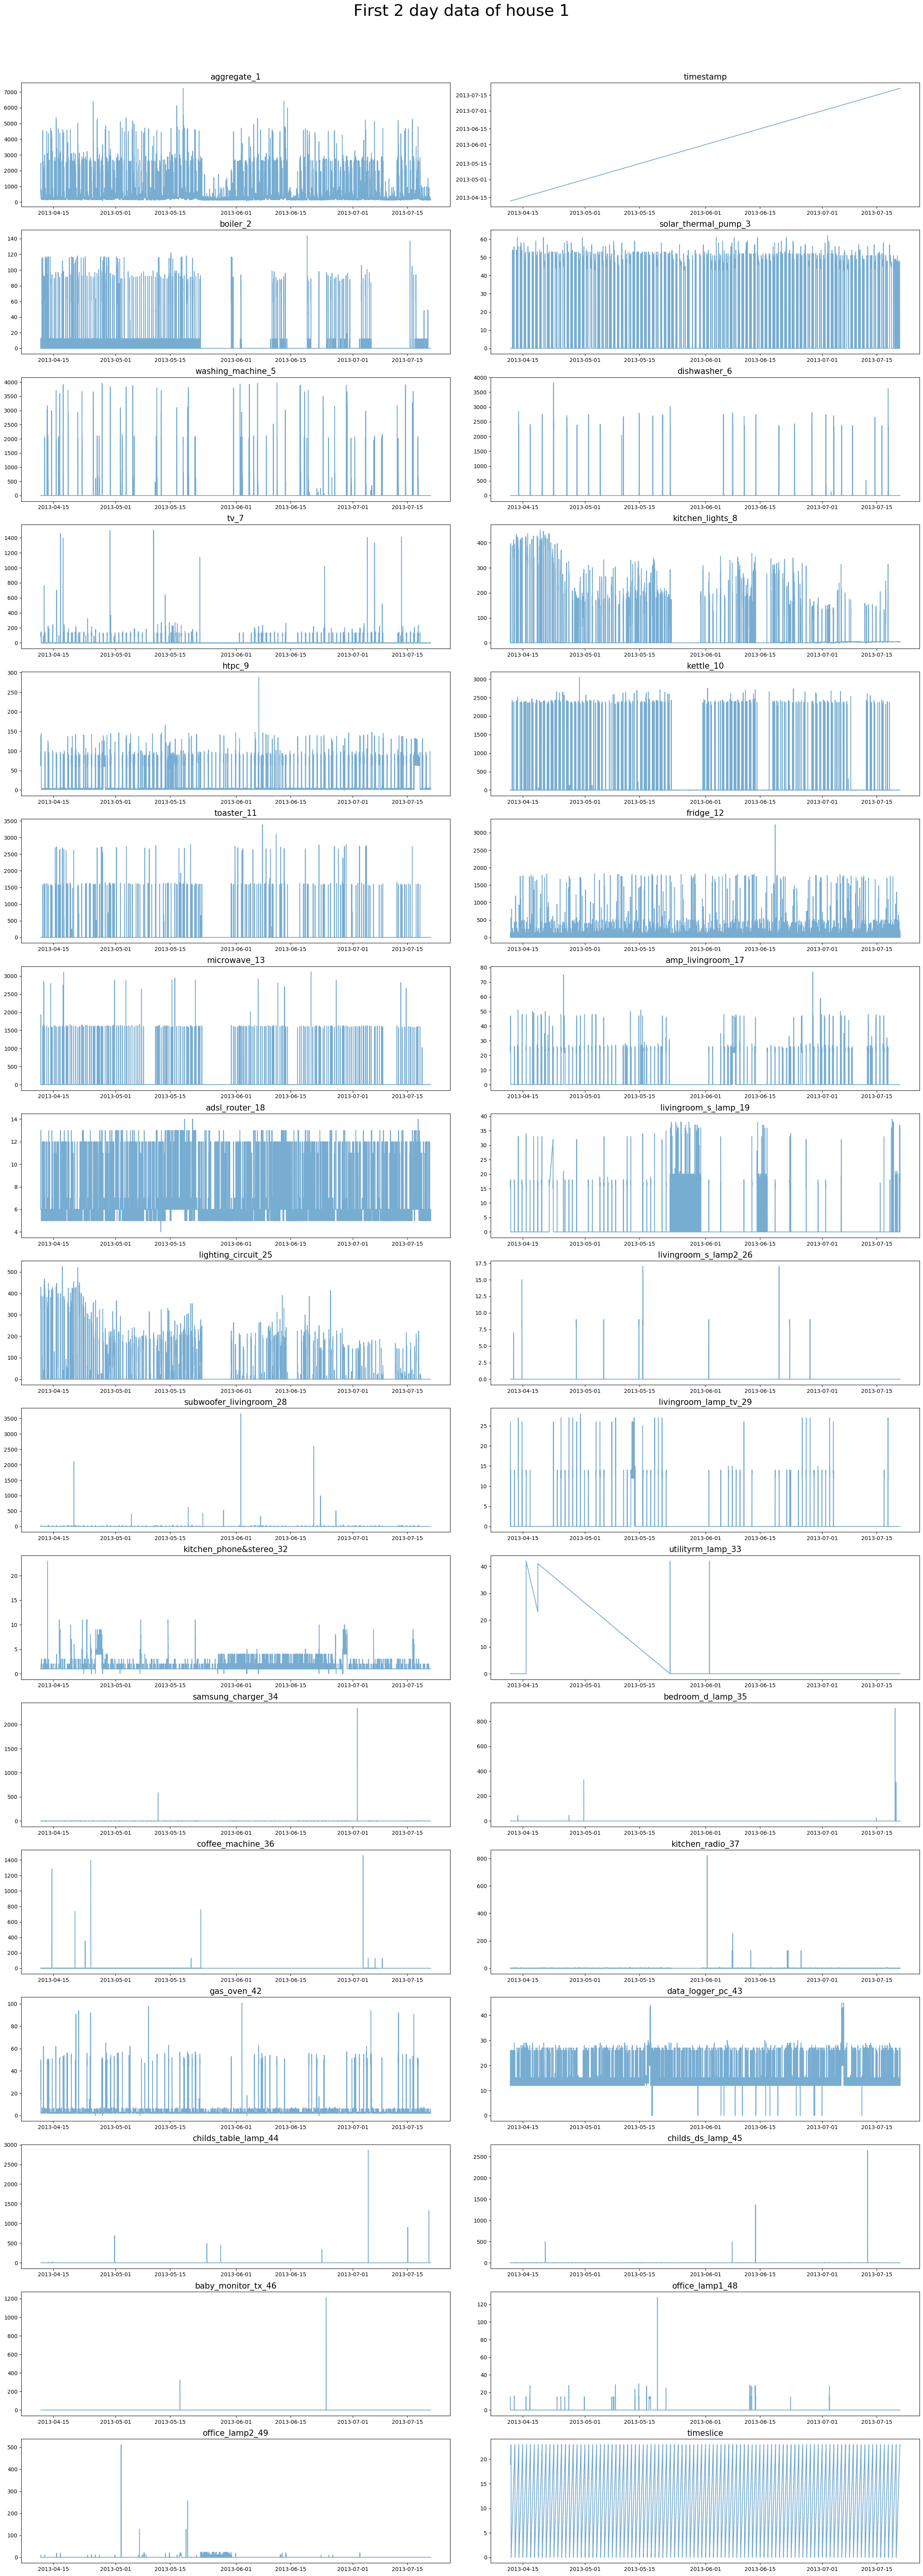

In [21]:
# Plot 2 first day data of house 1 and 2
def plot_df(df, title):
    apps = df.columns.values
    num_apps = len(apps) 
    fig, axes = plt.subplots((num_apps+1)//2,2, figsize=(24, num_apps*2) )
    for i, key in enumerate(apps):
        axes.flat[i].plot(df[key], alpha = 0.6)
        axes.flat[i].set_title(key, fontsize = '15')
    plt.suptitle(title, fontsize = '30')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

for i in range(1,2):
    plot_df(df[i].ix[:dates[i][50]], 'First 50 day data of house {}'.format(i))

In [22]:
# Separate house 1 data into train, validation and test data
df1_train = df[1].ix[:dates[1][800]]
df1_val = df[1].ix[dates[1][801]:dates[1][1200]]
df1_test = df[1].ix[dates[1][1201]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

df_train.shape:  (11088467, 34)
df_val.shape:  (5567381, 34)
df_test.shape:  (3187245, 34)


In [23]:
# Using aggregate_1 to predict tv_7
x_train = df1_train[['aggregate_1', 'timeslice']].values
y_train = df1_train.drop(['aggregate_1', 'timestamp'], axis=1).values
x_val = df1_val[['aggregate_1', 'timeslice']].values
y_val = df1_val.drop(['aggregate_1', 'timestamp'], axis=1).values
x_test = df1_test[['aggregate_1', 'timeslice']].values
y_test = df1_test.drop(['aggregate_1', 'timestamp'], axis=1).values
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)
print(y_train.shape[1])

(11088467, 2) (11088467, 32) (5567381, 2) (5567381, 32) (3187245, 2) (3187245, 32)
32


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError


from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

def compile_model(model):
    # output the model's structure
#     model.summary()

    # Model compilation
    optimizer = Adam(lr=0.01)
    # Consider regression metrics rather than accuracy : rmse, mae     
    model.compile(loss='mse', optimizer=optimizer,metrics=['accuracy', RootMeanSquaredError(), MeanAbsoluteError()])
    time_cb = TimingCallback()
    callbacks = [time_cb]

    # Model Training
    history = model.fit(x_train, y_train, epochs=3, batch_size=100, validation_data=(x_val, y_val), callbacks=callbacks)

    return history, sum(time_cb.logs)


model = Sequential()
# m.add(Flatten(input_shape=(943, 1)))
model.add(Dense(1000, activation='relu', input_dim = 2))
model.add(Dense(1000, activation='relu'))
model.add(Dense(y_train.shape[1],activation='linear'))

model.summary()

history, time_spent = compile_model(model)
# view_model_results(model, history)
print('Time spent', time_spent)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1000)              3000      
                                                                 
 dense_7 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_8 (Dense)             (None, 32)                32032     
                                                                 
Total params: 1,036,032
Trainable params: 1,036,032
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
110884/110885 [============================>.] - ETA: 0s - loss: 2994.4700 - accuracy: 0.4905 - root_mean_squared_error: 54.7218 - mean_absolute_error: 8.8340

KeyboardInterrupt: 

In [ ]:
def view_model_results(model, history):
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='test loss')
    plt.legend()
    plt.grid(True)
    plt.xlim([0,3])
    plt.ylim([0,1.0])
    plt.xlabel('epoch')

    fig.add_subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='test accuracy')
    plt.legend()
    plt.grid(True)
    plt.xlim([0,3])
    plt.ylim([0,1.0])
    plt.xlabel('epoch')


    print(history.history.keys())
    
view_model_results(model, history)